### Attention is All you Need

LSTM 에서 Attention은 그저 보조 도구에 불과했다.

LSTM에서 Attention이 무엇인지 설명하지는 않았는데, 여기서 한번에 설명하려고 한다.

우선 Transformer 의 전체 구조를 한번 보고 가자.

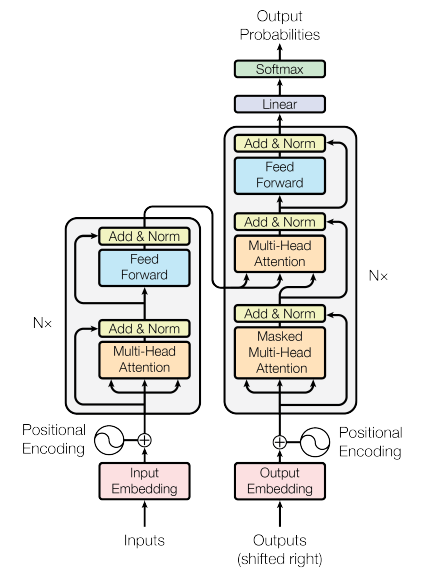

위 구조를 하나 하나 다 살펴 볼 것인데,

Embedding 은 이미 Text Embedding / RNN / LSTM 을 하면서 봤다.

그래서 굳이 다루지 않고 넘어가도 되고,

Positional Encoding 은 조금 뒤로 미뤄두도록 하겠다.

그러면 남는것은, Multi-Head Attention과 Feed Forward 뿐인데 (Add & Norm 은 특별한 Layer 가 아님.)

Feed Forward 는 그냥 단순히 은닉층 행렬 연산 하는것일 뿐이라, 굳이 다루지 않아도 된다.

남은것은 Attention 인데,

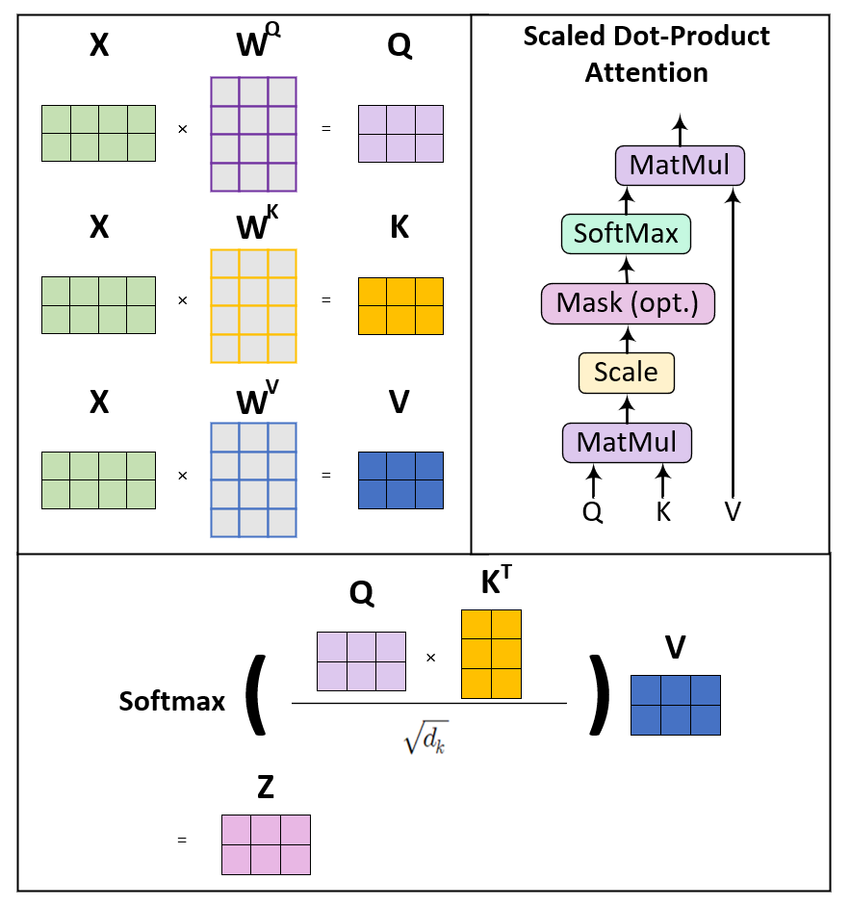

Attention 을 간략하게 그림으로 그려보면 위와 같다.

개념적으로 이해하면,

QK 의 곱은 큰 Matrix 가 되는데,

이것은 src - src 또는 src - tgt 가 어디에 더 집중하는지를 그려주는 표가 된다.




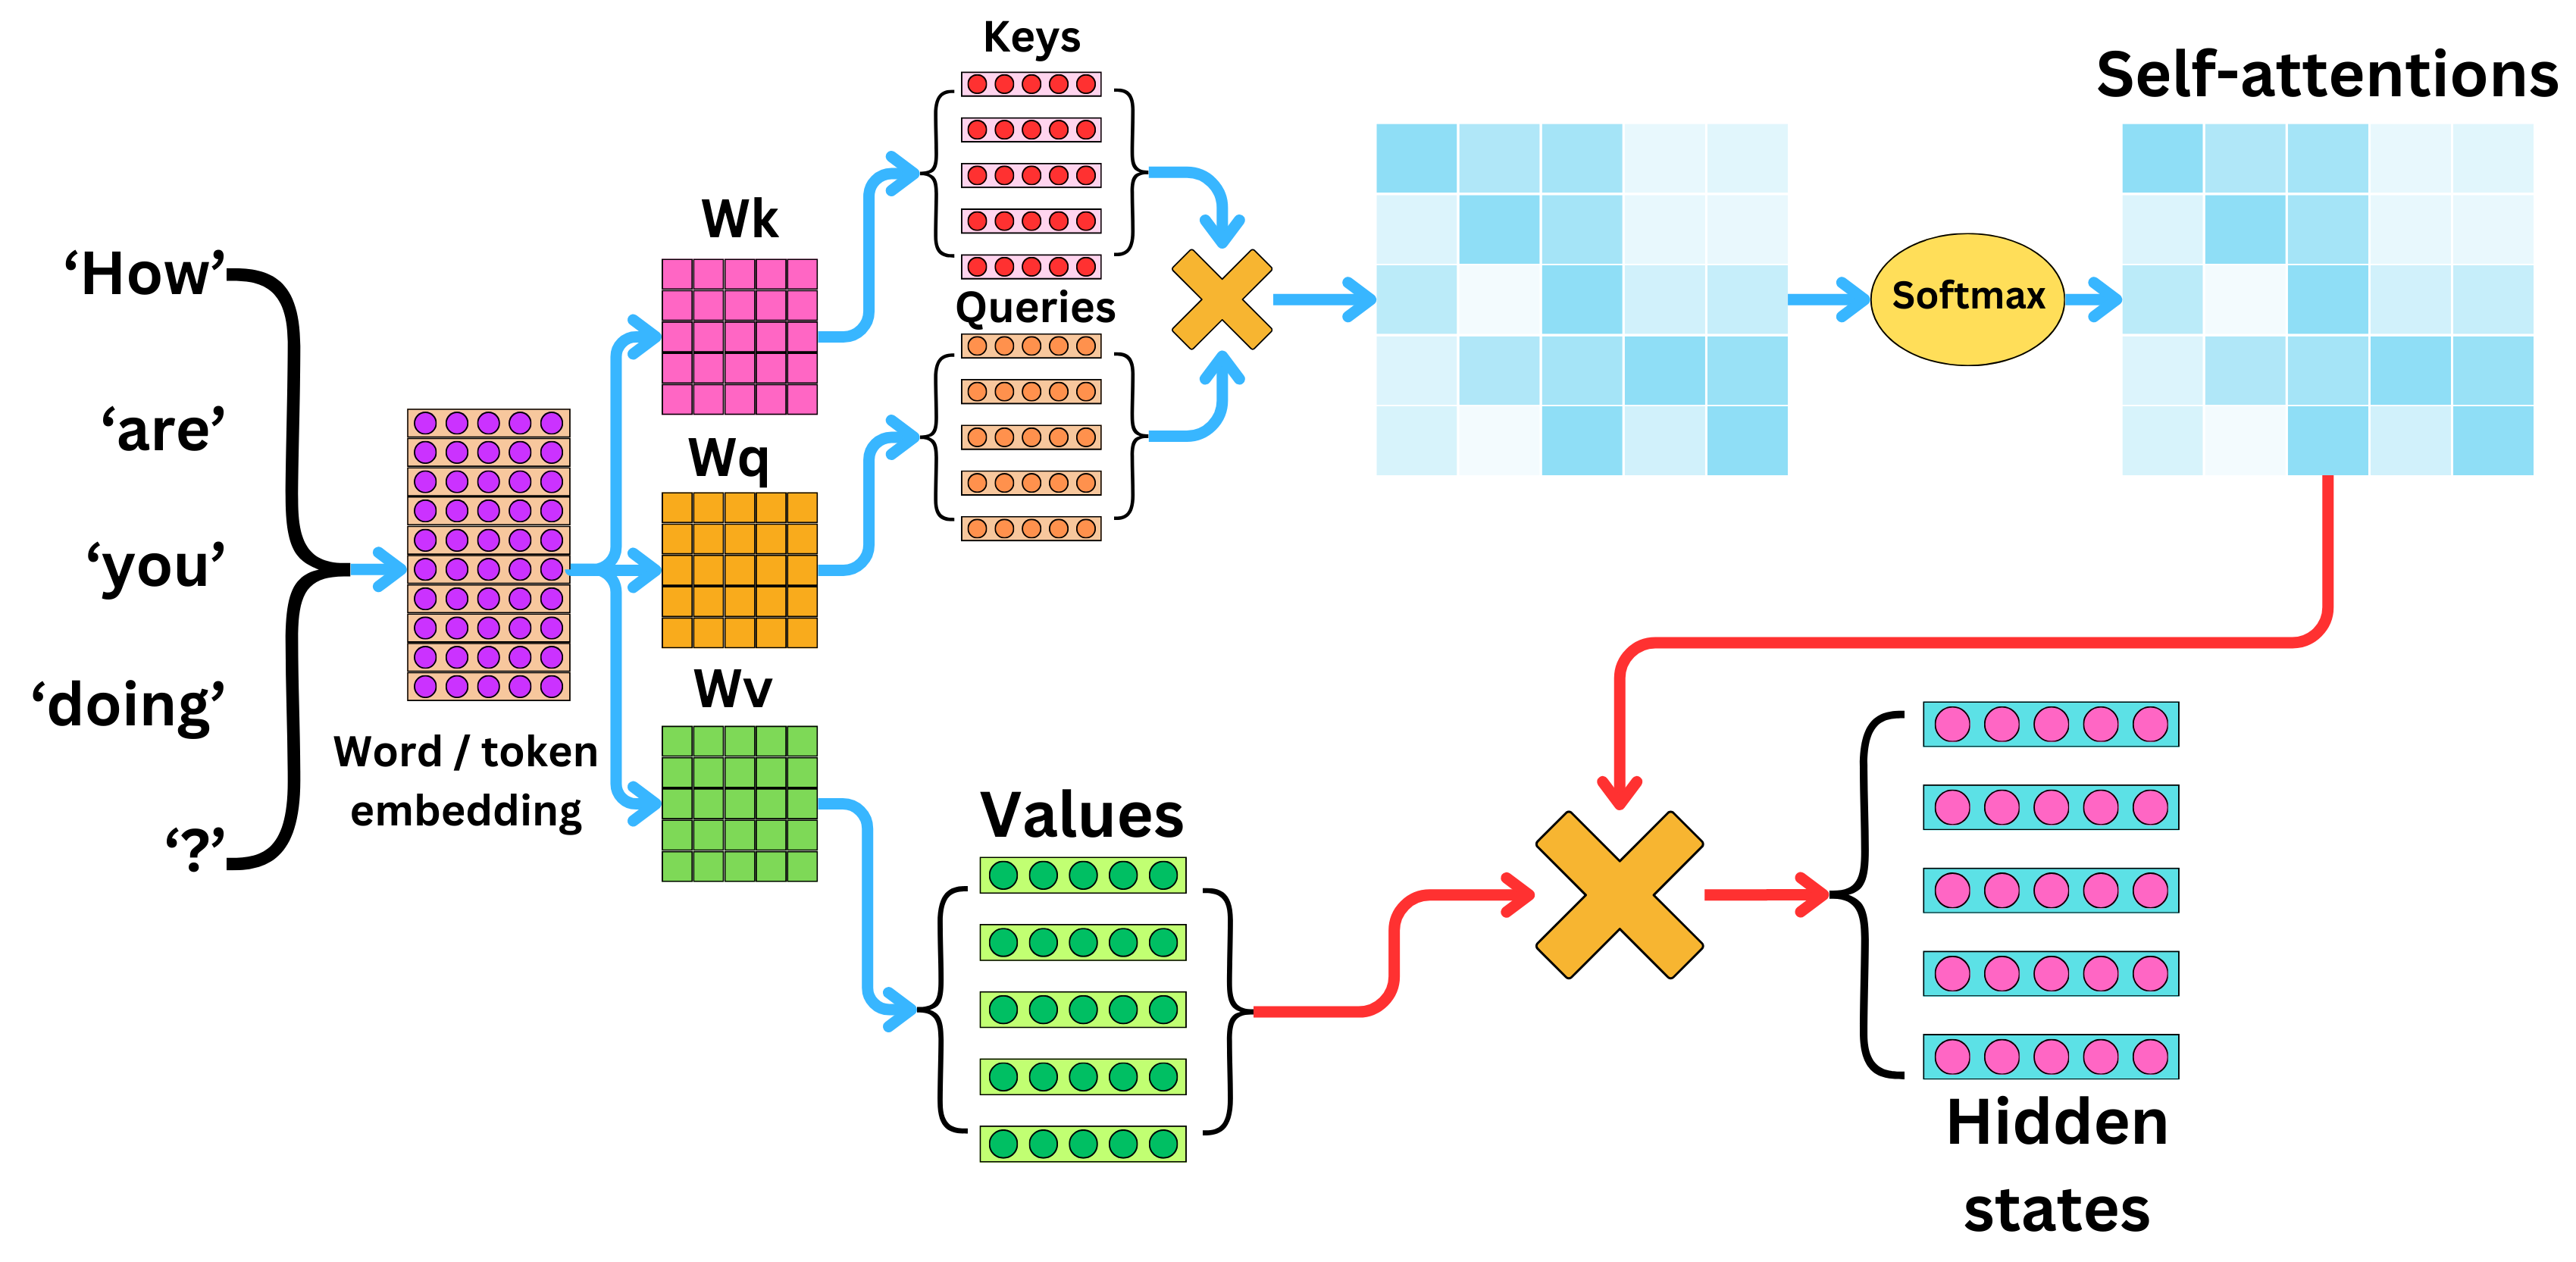

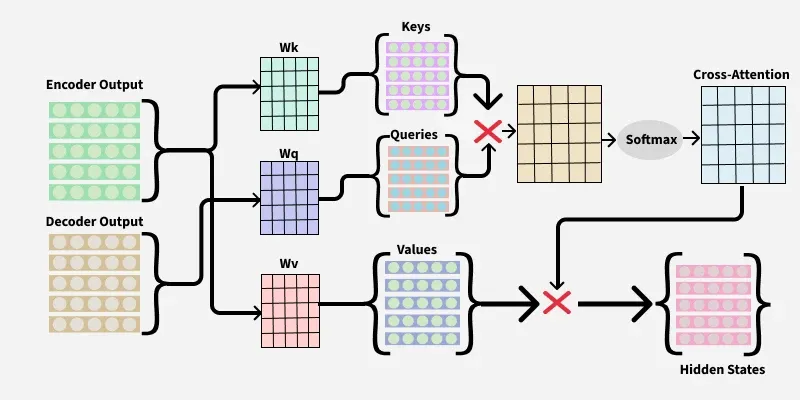

위 이미지에서 볼 수 있는 것 처럼, Key 와 Queries 를 곱해서, src - src 의 관계나 src - tgt 의 관계를 볼 수 있는 테이블을 만들어서 집중할 곳을 확인하고

V와 다시 곱해서 원래 차원과 같은 차원을 만든다.

이렇게 해서 여러 동일하게 생긴 Layer 를 쌓을 수 있다.

우선 이렇게 간단하게 감만 잡고, 직접 하나씩 코드로 확인 해 보자.

그 전에 Positional Encoding 만 잡고 넘어가자

### Positinoal Encoding 의 필요성

Self-Attention은 순서를 모른다
X의 행(토큰) 순서를 똑같이 섞으면, 출력도 똑같이 섞일 뿐 “구조적으로 동일”
즉, Attention만으로는 “첫 단어/마지막 단어/앞뒤 관계”가 구분되지 않음.
"개가 사람을 문다" 와 "사람이 개를 문다"는 토큰 집합은 같고 순서만 다른데
Attention은 순서 정보가 없으면 둘을 같은 종류의 데이터로 볼 위험이 커짐

LSTM 에서는 순서대로 데이터를 넣으니까, 이런 문제가 없었는데
Attention Table 로 한번에 보니까, 순서가 섞이는 문제가 된다.

### Positional Encoding 의 역할
 - 각 토큰이 문장 내 어디에 있는지”를 임베딩에 더해준다.

가장 단순한 형태:
 - X_pos = X + P
 - P[pos]가 위치에 따른 벡터

이걸로 Attention이
 - 누가 앞이고 뒤인지
 - 얼마나 떨어져 있는지
 - 순서가 바뀌면 의미가 바뀌는지
  를 학습할 수 있게 됨.

최초의 Transformer 논문에서는 이를 sin / cos 함수로 구현해서 사용했다.

구현단에서 직접 확인해 보자.

추가적으로 여기서 사용된 데이터는

AIHub 에서

https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&dataSetSn=126 

데이터를 사용해서

이 데이터를 가공해서

data 폴더 아래에

영어를 src.txt / 한국어를 tgt.txt 로

저장 한 파일을 사용하고 있다.

또한 Vocab 학습에는 SentencePiece 를 사용하고 있다.

https://arxiv.org/pdf/1808.06226.pdf

https://github.com/google/sentencepiece

SentencePiece 에 대한 정보는 위를 참조.

In [56]:
import math
import torch
import torch.nn as nn


class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 100):
        super().__init__()

        pe = torch.zeros(max_len, d_model)          # (위치, 차원)
        position = torch.arange(0, max_len).unsqueeze(1)  # (위치)

        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)  # 짝수 차원
        pe[:, 1::2] = torch.cos(position * div_term)  # 홀수 차원

        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x: (batch, seq_len, d_model)
        """
        seq_len = x.size(1)
        return x + self.pe[:seq_len]

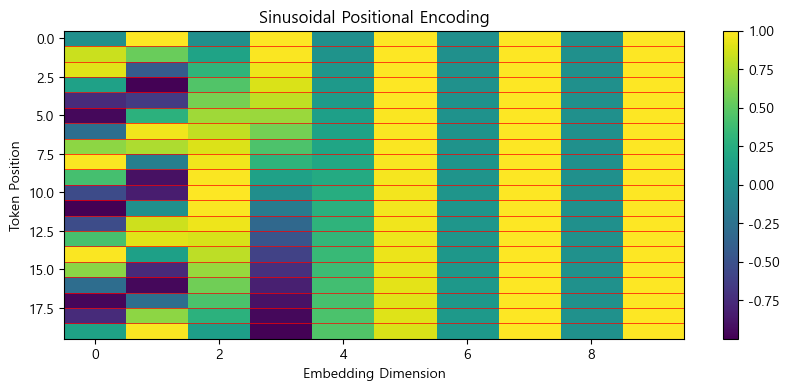

In [57]:
import matplotlib.pyplot as plt

d_model = 10
seq_len = 20

pos_enc = SinusoidalPositionalEncoding(d_model, max_len=seq_len)

dummy_x = torch.zeros(1, seq_len, d_model)
out = pos_enc(dummy_x)

pe_matrix = out[0]  # (seq_len, d_model)

plt.figure(figsize=(10, 4))
plt.imshow(pe_matrix, aspect="auto")
plt.colorbar()
plt.xlabel("Embedding Dimension")
plt.ylabel("Token Position")
plt.title("Sinusoidal Positional Encoding")

for y in range(seq_len):
    plt.axhline(y - 0.5, color="red", linewidth=0.5, alpha=1)

plt.show()

위 그림에서 볼 수 있는 것 처럼

빨간색 구분선으로 구분되어있는 것들이 단어들이다.

Embedding 차원이 10이라고 가정하면 저런 그림을 그릴 수 있게 된다.

Token Position 에 따라서 0번째 단어부터 19번째 단어까지 모두 색이 다르게 씌워진 것을 볼 수 있다.

이렇게 위치 정보를 Text Embedding 에 더해서 텍스트의 의미 + 위치 정보 를 학습하게 된다.

(빨간 선 하나가 토큰 하나이고, 한 줄 전체가 그 토큰의 위치 벡터)

In [58]:
import os
import sentencepiece as spm

def train_spm_single(
    input_path: str,
    model_prefix: str,
    vocab_size: int = 8000,
    character_coverage: float = 1.0,
    model_type: str = "unigram", 
):
    spm.SentencePieceTrainer.Train(
        input=input_path,
        model_prefix=model_prefix,
        vocab_size=vocab_size,
        character_coverage=character_coverage,
        model_type=model_type,
        pad_id=0,
        bos_id=1,
        eos_id=2,
        unk_id=3,
    )
    print("Saved:", f"{model_prefix}.model", f"{model_prefix}.vocab")

def ensure_spm(model_prefix, txt_path, vocab_size):
    model_path = f"{model_prefix}.model"
    vocab_path = f"{model_prefix}.vocab"

    if os.path.exists(model_path) and os.path.exists(vocab_path):
        print(f"[SKIP] SentencePiece already exists: {model_path}")
    else:
        print(f"[TRAIN] Training SentencePiece: {model_prefix}")
        train_spm_single(txt_path, model_prefix, vocab_size=vocab_size)

ensure_spm("data/spm_src", "data/src.txt", vocab_size=16000)
ensure_spm("data/spm_tgt", "data/tgt.txt", vocab_size=16000)

[SKIP] SentencePiece already exists: data/spm_src.model
[SKIP] SentencePiece already exists: data/spm_tgt.model


In [59]:
import sentencepiece as spm

class SPTokenizer:
    def __init__(self, model_path: str):
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(model_path)

        self.pad_id = self.sp.pad_id()
        self.bos_id = self.sp.bos_id()
        self.eos_id = self.sp.eos_id()
        self.unk_id = self.sp.unk_id()

    def encode(self, text: str, add_bos=True, add_eos=True):
        ids = self.sp.encode(text.strip(), out_type=int)
        if add_bos:
            ids = [self.bos_id] + ids
        if add_eos:
            ids = ids + [self.eos_id]
        return ids

    def decode(self, ids):
        cleaned = []
        for i in ids:
            if i == self.eos_id:
                break
            if i in (self.pad_id, self.bos_id):
                continue
            cleaned.append(i)
        return self.sp.decode(cleaned)

    @property
    def vocab_size(self):
        return self.sp.get_piece_size()

In [60]:
import sentencepiece as spm

tok_src = SPTokenizer("data/spm_src.model")
tok_tgt = SPTokenizer("data/spm_tgt.model")

def filter_parallel_by_token_len(
    src_path: str,
    tgt_path: str,
    tok_src,
    tok_tgt,
    max_src_len: int = 128,
    max_tgt_len: int = 128,
):
    with open(src_path, "r", encoding="utf-8") as f:
        src_lines = [x.rstrip("\n") for x in f]
    with open(tgt_path, "r", encoding="utf-8") as f:
        tgt_lines = [x.rstrip("\n") for x in f]

    assert len(src_lines) == len(tgt_lines)

    kept_src, kept_tgt = [], []
    drop_src = drop_tgt = 0
    src_lens, tgt_lens = [], []

    for s, t in zip(src_lines, tgt_lines):
        # BOS/EOS 포함 토큰 길이
        s_len = len(tok_src.sp.encode(s, out_type=int)) + 2
        t_len = len(tok_tgt.sp.encode(t, out_type=int)) + 2

        src_lens.append(s_len)
        tgt_lens.append(t_len)

        if s_len <= max_src_len and t_len <= max_tgt_len:
            kept_src.append(s)
            kept_tgt.append(t)
        else:
            if s_len > max_src_len: drop_src += 1
            if t_len > max_tgt_len: drop_tgt += 1

    total = len(src_lines)
    kept = len(kept_src)

    print("=== Length Filter Summary ===")
    print(f"Total pairs        : {total}")
    print(f"Kept pairs         : {kept} ({kept/total*100:.2f}%)")
    print(f"Dropped by src_len : {drop_src}")
    print(f"Dropped by tgt_len : {drop_tgt}")

    return kept_src, kept_tgt

kept_src, kept_tgt = filter_parallel_by_token_len(
    src_path="data/src.txt",
    tgt_path="data/tgt.txt",
    tok_src=tok_src,
    tok_tgt=tok_tgt,
    max_src_len=32,
    max_tgt_len=32,
)


=== Length Filter Summary ===
Total pairs        : 1602418
Kept pairs         : 833068 (51.99%)
Dropped by src_len : 730725
Dropped by tgt_len : 618580


In [61]:
import torch
from torch.utils.data import Dataset, DataLoader

class ParallelSPDatasetFromList(torch.utils.data.Dataset):
    def __init__(self, src_lines, tgt_lines, tok_src, tok_tgt, max_len=128):
        assert len(src_lines) == len(tgt_lines)
        self.src_lines = src_lines
        self.tgt_lines = tgt_lines
        self.tok_src = tok_src
        self.tok_tgt = tok_tgt
        self.max_len = max_len

    def __len__(self):
        return len(self.src_lines)

    def __getitem__(self, idx):
        src_ids = self.tok_src.encode(self.src_lines[idx], add_bos=True, add_eos=True)[: self.max_len]
        tgt_ids = self.tok_tgt.encode(self.tgt_lines[idx], add_bos=True, add_eos=True)[: self.max_len]
        return torch.tensor(src_ids), torch.tensor(tgt_ids)

def collate_pad_sp(batch, pad_id_src: int, pad_id_tgt: int):
    srcs, tgts = zip(*batch)
    src_len = max(x.size(0) for x in srcs)
    tgt_len = max(x.size(0) for x in tgts)

    src_batch = torch.full((len(batch), src_len), pad_id_src, dtype=torch.long)
    tgt_batch = torch.full((len(batch), tgt_len), pad_id_tgt, dtype=torch.long)

    for i, (s, t) in enumerate(zip(srcs, tgts)):
        src_batch[i, : s.size(0)] = s
        tgt_batch[i, : t.size(0)] = t

    return src_batch, tgt_batch

ds = ParallelSPDatasetFromList(kept_src, kept_tgt, tok_src, tok_tgt, max_len=64)

dl = DataLoader(
    ds,
    batch_size=128,
    shuffle=True,
    collate_fn=lambda b: collate_pad_sp(b, tok_src.pad_id, tok_tgt.pad_id),
)

src_batch, tgt_batch = next(iter(dl))

In [62]:
from torch.utils.data import Subset, DataLoader
import random

def make_small_dl(ds, n=64, batch_size=16, seed=42):
    rng = random.Random(seed)
    idx = list(range(len(ds)))
    rng.shuffle(idx)
    idx = idx[:n]
    small_ds = Subset(ds, idx)

    small_dl = DataLoader(
        small_ds,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda b: collate_pad_sp(b, tok_src.pad_id, tok_tgt.pad_id),
    )
    return small_ds, small_dl, idx

small_ds, small_dl, small_idx = make_small_dl(ds, n=64, batch_size=16)
print("small subset size:", len(small_ds))

small subset size: 64


In [63]:
# padding mask (True가 mask)
src_key_padding_mask = (src_batch == tok_src.pad_id)  # [B, Ts]
tgt_key_padding_mask = (tgt_batch == tok_tgt.pad_id)  # [B, Tt]

def make_causal_mask(T, device):
    return torch.triu(torch.ones(T, T, dtype=torch.bool, device=device), diagonal=1)  # True=mask

C:\Users\chech\AppData\Local\Temp\ipykernel_38528\559163338.py:134: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


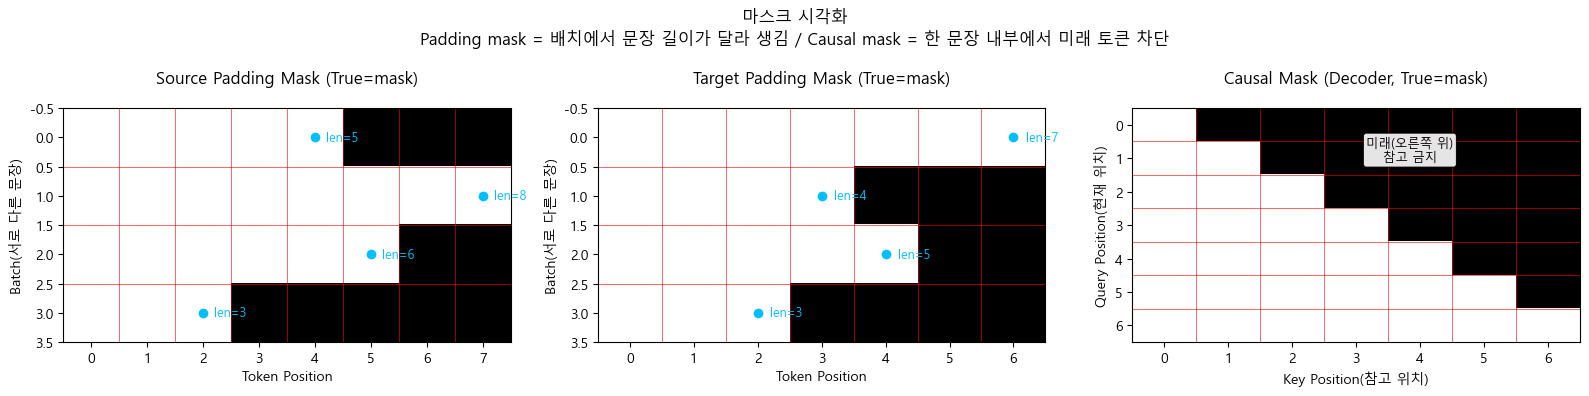

In [64]:
# padding mask / causal mask 시각화 (라벨 포함)
# - Padding mask: 배치 내 "서로 다른 문장 길이" 때문에 생김 (문장별로 PAD 위치가 다름)
# - Causal mask: "한 문장 내부"에서 미래 토큰을 못 보게 하는 마스크

import torch
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams["font.family"] = "Malgun Gothic"
rcParams["axes.unicode_minus"] = False
# 0) 예시 batch (서로 길이 다른 문장 -> PAD로 맞춤)
pad_id = 0

src_batch = torch.tensor([
    [1, 5, 6, 7, 2, 0, 0, 0],   # 문장 길이 5 (BOS ... EOS), 나머지 PAD
    [1, 8, 9, 6, 5, 4, 3, 2],   # 문장 길이 8
    [1, 3, 4, 5, 6, 2, 0, 0],   # 문장 길이 6
    [1, 7, 2, 0, 0, 0, 0, 0],   # 문장 길이 3
])

tgt_batch = torch.tensor([
    [1, 4, 5, 6, 3, 8, 2],      # 문장 길이 7
    [1, 7, 8, 2, 0, 0, 0],      # 문장 길이 4
    [1, 3, 4, 5, 2, 0, 0],      # 문장 길이 5
    [1, 9, 2, 0, 0, 0, 0],      # 문장 길이 3
])

B, Ts = src_batch.shape
_, Tt = tgt_batch.shape 


# 1) masks
src_key_padding_mask = (src_batch == pad_id)  # [B, Ts]  True=mask
tgt_key_padding_mask = (tgt_batch == pad_id)  # [B, Tt]  True=mask

def make_causal_mask(T: int, device=None):  
    return torch.triu(torch.ones(T, T, dtype=torch.bool, device=device), diagonal=1)  # [T,T], True=mask

causal_mask = make_causal_mask(Tt)


# 2) draw helpers
def draw_mask(ax, mask, title, xlabel, ylabel, top_label=None, left_label=None):
    ax.imshow(mask, cmap="gray_r", aspect="auto")  # True=검정(마스크), False=흰색(허용)

    for y in range(mask.size(0) + 1):
        ax.axhline(y - 0.5, color="red", linewidth=0.6, alpha=0.7)
    for x in range(mask.size(1) + 1):
        ax.axvline(x - 0.5, color="red", linewidth=0.6, alpha=0.7)

    ax.set_title(title, pad=18)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if top_label is not None:
        ax.text(
            0.5, 1.10, top_label,
            transform=ax.transAxes, ha="center", va="bottom",
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.9)
        )
    if left_label is not None:
        ax.text(
            -0.18, 0.5, left_label,
            transform=ax.transAxes, ha="right", va="center", rotation=90,
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.9)
        )

def annotate_sentence_lengths(ax, batch_ids, pad_id=0):
    B, T = batch_ids.shape
    for b in range(B):
        # pad 시작 위치 = 실제 길이
        row = batch_ids[b].tolist()
        try:
            L = row.index(pad_id)
        except ValueError:
            L = T
        # 문장 끝 위치 표시 (L-1)
        x = max(L - 1, 0)
        ax.plot([x], [b], marker="o", markersize=6, color="deepskyblue")
        ax.text(
            x + 0.2, b, f"len={L}",
            color="deepskyblue", fontsize=9, va="center"
        )

def annotate_lengths(ax, batch_ids, pad_id=0):
    B, T = batch_ids.shape
    for b in range(B):
        row = batch_ids[b].tolist()
        try:
            L = row.index(pad_id)
        except ValueError:
            L = T
        x = max(L - 1, 0)
        ax.plot([x], [b], marker="o", markersize=6, color="deepskyblue")
        ax.text(x + 0.2, b, f"len={L}", color="deepskyblue", fontsize=9, va="center")

fig, axes = plt.subplots(1, 3, figsize=(16, 4), constrained_layout=True)

fig.suptitle(
    "마스크 시각화\n"
    "Padding mask = 배치에서 문장 길이가 달라 생김 / Causal mask = 한 문장 내부에서 미래 토큰 차단",
    fontsize=12
)

draw_mask(
    axes[0], src_key_padding_mask,
    "Source Padding Mask (True=mask)",
    "Token Position", "Batch(서로 다른 문장)"
)
annotate_lengths(axes[0], src_batch, pad_id)

draw_mask(
    axes[1], tgt_key_padding_mask,
    "Target Padding Mask (True=mask)",
    "Token Position", "Batch(서로 다른 문장)"
)
annotate_lengths(axes[1], tgt_batch, pad_id)

draw_mask(
    axes[2], causal_mask,
    "Causal Mask (Decoder, True=mask)",
    "Key Position(참고 위치)", "Query Position(현재 위치)"
)

axes[2].text(
    0.62, 0.82, "미래(오른쪽 위)\n참고 금지",
    transform=axes[2].transAxes,
    ha="center", va="center", fontsize=9,
    bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="black", alpha=0.9)
)

plt.tight_layout()
plt.show()


In [67]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 2048):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # [T, D]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # [T,1]
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)  # [T,D]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B,T,D]
        T = x.size(1)
        return x + self.pe[:T].unsqueeze(0)

def make_causal_mask(T: int, device=None):
    return torch.triu(torch.ones(T, T, dtype=torch.bool, device=device), diagonal=1)


In [66]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads

        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)
        self.w_o = nn.Linear(d_model, d_model, bias=False)
        self.drop = nn.Dropout(dropout)

    def forward(
        self,
        q_in, k_in, v_in,
        *,
        attn_mask=None,              # [Tq, Tk] True=mask
        key_padding_mask=None,       # [B, Tk] True=mask (KEY 쪽 PAD)
        query_padding_mask=None,     # [B, Tq] True=mask (QUERY 쪽 PAD)
    ):
        """
        q_in: [B, Tq, D]
        k_in,v_in: [B, Tk, D]
        """
        B, Tq, D = q_in.shape
        Tk = k_in.size(1)

        q = self.w_q(q_in).view(B, Tq, self.n_heads, self.d_head).transpose(1, 2)  # [B,H,Tq,d]
        k = self.w_k(k_in).view(B, Tk, self.n_heads, self.d_head).transpose(1, 2)  # [B,H,Tk,d]
        v = self.w_v(v_in).view(B, Tk, self.n_heads, self.d_head).transpose(1, 2)  # [B,H,Tk,d]

        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.d_head)  # [B,H,Tq,Tk]

        if attn_mask is not None:
            scores = scores.masked_fill(attn_mask.unsqueeze(0).unsqueeze(0), -1e9)

        if key_padding_mask is not None:
            scores = scores.masked_fill(key_padding_mask.unsqueeze(1).unsqueeze(2), -1e9)

        attn = F.softmax(scores, dim=-1)
        attn = self.drop(attn)

        out = attn @ v  # [B,H,Tq,d]
        out = out.transpose(1, 2).contiguous().view(B, Tq, D)  # [B,Tq,D]
        out = self.w_o(out)

        return out


In [69]:
class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout),
        )
    def forward(self, x): return self.net(x)


class EncoderBlock(nn.Module):
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, *, src_key_padding_mask=None):
        # Pre-LN
        x_norm = self.norm1(x)
        x = x + self.self_attn(
            x_norm, x_norm, x_norm,
            key_padding_mask=src_key_padding_mask,         # key(PAD) 가림
            query_padding_mask=src_key_padding_mask,       # query(PAD) 출력 0
        )
        x = x + self.ffn(self.norm2(x))
        return x


In [70]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ffn = FeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

    def forward(self, x, enc_out, *, tgt_key_padding_mask=None, memory_key_padding_mask=None, causal_mask=None):
        # 1) masked self-attn (미래 차단 + tgt pad 차단)
        x_norm = self.norm1(x)
        x = x + self.self_attn(
            x_norm, x_norm, x_norm,
            attn_mask=causal_mask,
            key_padding_mask=tgt_key_padding_mask,         # key(PAD) 가림
            query_padding_mask=tgt_key_padding_mask,       # query(PAD) 출력 0
        )

        # 2) cross-attn (encoder 출력 참고 + src pad 차단)
        x_norm = self.norm2(x)
        x = x + self.cross_attn(
            x_norm, enc_out, enc_out,
            key_padding_mask=memory_key_padding_mask,      # src key(PAD) 가림
            query_padding_mask=tgt_key_padding_mask,       # tgt query(PAD) 출력 0
        )

        # 3) ffn
        x = x + self.ffn(self.norm3(x))
        return x


In [71]:
class TransformerSeq2Seq(nn.Module):
    def __init__(
        self,
        src_vocab_size: int,
        tgt_vocab_size: int,
        *,
        d_model=512,
        n_heads=8,
        d_ff=512,
        enc_layers=6,
        dec_layers=3,
        max_len=64,
        dropout=0.1,
        pad_id_src=0,
        pad_id_tgt=0,
    ):
        super().__init__()
        self.pad_id_src = pad_id_src
        self.pad_id_tgt = pad_id_tgt
        self.emb_scale = math.sqrt(d_model)
        self.src_emb = nn.Embedding(src_vocab_size, d_model, padding_idx=pad_id_src)
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model, padding_idx=pad_id_tgt)
        self.pos_enc = SinusoidalPositionalEncoding(d_model, max_len=250)
        self.drop = nn.Dropout(dropout)

        self.enc = nn.ModuleList(
            [EncoderBlock(d_model, n_heads, d_ff, dropout) for _ in range(enc_layers)]
        )
        self.dec = nn.ModuleList(
            [DecoderBlock(d_model, n_heads, d_ff, dropout) for _ in range(dec_layers)]
        )

        self.norm_enc = nn.LayerNorm(d_model)
        self.norm_dec = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, tgt_vocab_size, bias=False)

    def encode(self, src_ids):
        src_pad_mask = (src_ids == self.pad_id_src)  # [B,Ts] True=mask
        x = self.drop(self.pos_enc(self.src_emb(src_ids) * self.emb_scale))
        for blk in self.enc:
            x = blk(x, src_key_padding_mask=src_pad_mask)
        return self.norm_enc(x), src_pad_mask

    def decode(self, tgt_ids, enc_out, src_pad_mask):
        tgt_pad_mask = (tgt_ids == self.pad_id_tgt)  # [B,Tt]
        Tt = tgt_ids.size(1)
        causal = make_causal_mask(Tt, device=tgt_ids.device)  # [Tt,Tt] True=mask

        x = self.drop(self.pos_enc(self.tgt_emb(tgt_ids) * self.emb_scale))
        for blk in self.dec:
            x = blk(
                x,
                enc_out,
                tgt_key_padding_mask=tgt_pad_mask,
                memory_key_padding_mask=src_pad_mask,
                causal_mask=causal,
            )
        x = self.norm_dec(x)
        return self.lm_head(x)  # [B,Tt,Vt]

    def forward(self, src_ids, tgt_ids):
        enc_out, src_pad_mask = self.encode(src_ids)
        logits = self.decode(tgt_ids, enc_out, src_pad_mask)
        return logits


In [72]:
tok_src = SPTokenizer("data/spm_src.model")
tok_tgt = SPTokenizer("data/spm_tgt.model")

print("=== SRC TOKENIZER ===")
print("pad_id:", tok_src.pad_id)
print("bos_id:", tok_src.bos_id)
print("eos_id:", tok_src.eos_id)
print("unk_id:", tok_src.unk_id)
print("vocab_size:", tok_src.vocab_size)

print("\n=== TGT TOKENIZER ===")
print("pad_id:", tok_tgt.pad_id)
print("bos_id:", tok_tgt.bos_id)
print("eos_id:", tok_tgt.eos_id)
print("unk_id:", tok_tgt.unk_id)
print("vocab_size:", tok_tgt.vocab_size)


=== SRC TOKENIZER ===
pad_id: 0
bos_id: 1
eos_id: 2
unk_id: 3
vocab_size: 16000

=== TGT TOKENIZER ===
pad_id: 0
bos_id: 1
eos_id: 2
unk_id: 3
vocab_size: 16000


In [73]:
src_sentences = [
    "I like machine learning",
    "This model learns translation",
]

tgt_sentences = [
    "나는 기계 학습을 좋아한다",
    "이 모델은 번역을 학습한다",
]

def show_tokenization(tok, sentences, name):
    print(f"\n===== {name} TOKENIZATION =====")
    for s in sentences:
        ids = tok.encode(s, add_bos=True, add_eos=True)
        pieces = [tok.sp.id_to_piece(i) for i in ids]

        print("\nSentence:")
        print(" ", s)
        print("Token IDs:")
        print(" ", ids)
        print("Pieces:")
        print(" ", pieces)


show_tokenization(tok_src, src_sentences, "SRC")
show_tokenization(tok_tgt, tgt_sentences, "TGT")



===== SRC TOKENIZATION =====

Sentence:
  I like machine learning
Token IDs:
  [1, 20, 114, 2859, 1351, 2]
Pieces:
  ['<s>', '▁I', '▁like', '▁machine', '▁learning', '</s>']

Sentence:
  This model learns translation
Token IDs:
  [1, 107, 1119, 1434, 11, 5233, 2]
Pieces:
  ['<s>', '▁This', '▁model', '▁learn', 's', '▁translation', '</s>']

===== TGT TOKENIZATION =====

Sentence:
  나는 기계 학습을 좋아한다
Token IDs:
  [1, 114, 3232, 1849, 5, 981, 110, 2]
Pieces:
  ['<s>', '▁나는', '▁기계', '▁학습', '을', '▁좋아', '한다', '</s>']

Sentence:
  이 모델은 번역을 학습한다
Token IDs:
  [1, 31, 1420, 14, 3648, 5, 1849, 110, 2]
Pieces:
  ['<s>', '▁이', '▁모델', '은', '▁번역', '을', '▁학습', '한다', '</s>']


In [75]:
def round_trip_test(tok, sentence):
    ids = tok.encode(sentence, add_bos=True, add_eos=True)
    decoded = tok.decode(ids)

    print("\nOriginal :", sentence)
    print("Decoded  :", decoded)
    print("Match    :", sentence.strip() == decoded.strip())


print("\n=== ROUND TRIP TEST ===")
round_trip_test(tok_src, src_sentences[0])
round_trip_test(tok_tgt, tgt_sentences[0])


=== ROUND TRIP TEST ===

Original : I like machine learning
Decoded  : I like machine learning
Match    : True

Original : 나는 기계 학습을 좋아한다
Decoded  : 나는 기계 학습을 좋아한다
Match    : True


In [76]:
src_batch, tgt_batch = next(iter(dl))

print("SRC batch shape:", src_batch.shape)
print("TGT batch shape:", tgt_batch.shape)

i = 0
print("\n=== SRC BATCH SAMPLE ===")
print("IDs:", src_batch[i].tolist())
print("Tokens:", [tok_src.sp.id_to_piece(x) for x in src_batch[i].tolist()])

print("\n=== TGT BATCH SAMPLE ===")
print("IDs:", tgt_batch[i].tolist())
print("Tokens:", [tok_tgt.sp.id_to_piece(x) for x in tgt_batch[i].tolist()])


SRC batch shape: torch.Size([128, 32])
TGT batch shape: torch.Size([128, 32])

=== SRC BATCH SAMPLE ===
IDs: [1, 160, 473, 66, 593, 9, 996, 4, 211, 17, 4932, 337, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokens: ['<s>', '▁President', '▁Trump', '▁also', '▁seems', '▁to', '▁understand', '▁the', '▁need', '▁for', '▁monetary', '▁policy', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

=== TGT BATCH SAMPLE ===
IDs: [1, 496, 941, 19, 12093, 6, 3430, 1181, 8492, 42, 2577, 498, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokens: ['<s>', '▁트럼프', '▁대통령', '도', '▁통화정책', '이', '▁필요하다는', '▁점을', '▁이해하고', '▁있는', '▁듯', '▁보인다', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


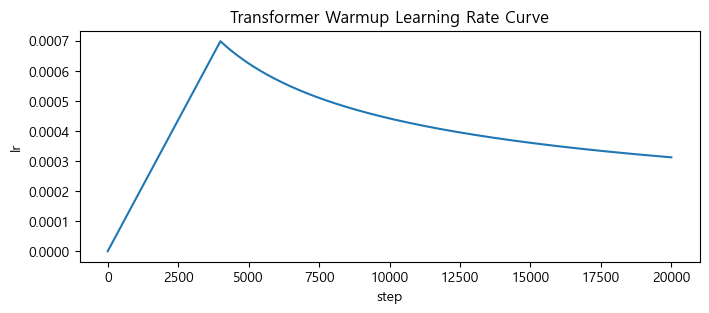

In [77]:
import matplotlib.pyplot as plt

def preview_lr_curve(d_model=256, warmup_steps=4000, scale=1.0, steps=20000):
    lrs = []
    for s in range(1, steps + 1):
        lr = (d_model ** -0.5) * min(s ** -0.5, s * (warmup_steps ** -1.5))
        lrs.append(lr * scale)
    plt.figure(figsize=(8,3))
    plt.plot(lrs)
    plt.title("Transformer Warmup Learning Rate Curve")
    plt.xlabel("step")
    plt.ylabel("lr")
    plt.show()

preview_lr_curve(d_model=512, warmup_steps=4000, steps=20000)


In [78]:
class TransformerWarmupScheduler:
    """
    Attention is All You Need 스타일:
      lr = (d_model^-0.5) * min(step^-0.5, step * warmup^-1.5)
    """
    def __init__(self, optimizer, d_model: int, warmup_steps: int = 4000, scale: float = 1.0):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.scale = scale
        self.step_num = 0

    def step(self):
        self.step_num += 1
        s = self.step_num
        lr = (self.d_model ** -0.5) * min(s ** -0.5, s * (self.warmup_steps ** -1.5))
        lr *= self.scale
        for pg in self.optimizer.param_groups:
            pg["lr"] = lr
        return lr

    def get_lr(self):
        return self.optimizer.param_groups[0]["lr"]


In [79]:
import math
import torch
import torch.nn as nn

def init_transformer_weights(module: nn.Module, d_model: int):
    # Linear 계열
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)

    # Embedding 계열
    elif isinstance(module, nn.Embedding):
        # 논문 스타일 스케일: std = 1/sqrt(d_model)
        nn.init.normal_(module.weight, mean=0.0, std=(d_model ** -0.5))
        # padding_idx가 있으면 거기는 0으로
        if module.padding_idx is not None:
            with torch.no_grad():
                module.weight[module.padding_idx].fill_(0.0)

    # LayerNorm
    elif isinstance(module, nn.LayerNorm):
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)


In [80]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

n_heads = 8
d_model = 512
d_ff = 2048
enc_layers = 3
dec_layers = 3
max_len = 70
dropout = 0.1
warmup_steps = 200

model = TransformerSeq2Seq(
    src_vocab_size=tok_src.vocab_size,
    tgt_vocab_size=tok_tgt.vocab_size,
    d_model=d_model,
    n_heads=n_heads,
    d_ff=d_ff,
    enc_layers=enc_layers,
    dec_layers=dec_layers,
    max_len=max_len,
    dropout=dropout,
    pad_id_src=tok_src.pad_id,
    pad_id_tgt=tok_tgt.pad_id,
).to(device)

model.apply(lambda m: init_transformer_weights(m, d_model=d_model))

criterion = nn.CrossEntropyLoss(ignore_index=tok_tgt.pad_id)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.01)

'''
scheduler = TransformerWarmupScheduler(
    optimizer,
    d_model=d_model,
    warmup_steps=warmup_steps,
    scale=3.0,
)
'''

device: cuda


'\nscheduler = TransformerWarmupScheduler(\n    optimizer,\n    d_model=d_model,\n    warmup_steps=warmup_steps,\n    scale=3.0,\n)\n'

In [81]:
def count_params(model):
    return sum(p.numel() for p in model.parameters())

def fmt(n):
    if n >= 1e6: return f"{n/1e6:.2f}M"
    if n >= 1e3: return f"{n/1e3:.2f}K"
    return str(n)

print(fmt(count_params(model))) 

46.63M


In [82]:
import time
import torch
import torch.nn as nn
from pathlib import Path

criterion = nn.CrossEntropyLoss(ignore_index=tok_tgt.pad_id)

def train_one_epoch(
    model,
    dl,
    optimizer,
    criterion,
    scheduler,
    *,
    epoch: int,
    save_dir: str = "ckpt",
    grad_clip: float = 1.0,
    log_every: int = 200,
):
    model.train()
    total_loss = 0.0

    Path(save_dir).mkdir(parents=True, exist_ok=True)

    step_start = time.perf_counter()

    for step, (src_ids, tgt_ids) in enumerate(dl, start=1):
        src_ids = src_ids.to(device)
        tgt_ids = tgt_ids.to(device)

        tgt_in  = tgt_ids[:, :-1]
        tgt_out = tgt_ids[:, 1:]

        logits = model(src_ids, tgt_in)
        
        loss = criterion(
            logits.reshape(-1, logits.size(-1)),
            tgt_out.reshape(-1)
        )

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()
        total_loss += loss.item()

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        step_time = time.perf_counter() - step_start
        step_start = time.perf_counter()

        if step % log_every == 0:
            token_loss = loss.item()
            with torch.no_grad():
                pred = logits.argmax(dim=-1)
                nonpad = (tgt_out != tok_tgt.pad_id)
                token_acc = (
                    (pred.eq(tgt_out) & nonpad).sum().item()
                    / max(1, nonpad.sum().item())
                )

            print(
                f"[epoch {epoch}] "
                f"step {step:5d} | "
                f"loss(avg) {total_loss/step:.4f} | "
                f"token_loss {token_loss:.4f} | "
                f"token_acc {token_acc*100:.2f}% | "
                f"time/step {step_time*1000:.1f} ms"
            )

    avg_loss = total_loss / max(1, len(dl))

    ckpt_path = Path(save_dir) / f"transformer_epoch_{epoch:03d}.pt"

    torch.save(
        {
            "epoch": epoch,
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "avg_loss": avg_loss,
            "src_spm": "data/spm_src.model",
            "tgt_spm": "data/spm_tgt.model",
        },
        ckpt_path,
    )

    print(f"[epoch {epoch}] checkpoint saved to {ckpt_path}")
    print(f"[epoch {epoch}] avg_loss = {avg_loss:.4f}")

    return avg_loss


In [96]:
@torch.no_grad()
def greedy_translate(model, src_text: str, max_len: int = 70):
    model.eval()

    src_ids = tok_src.encode(src_text, add_bos=True, add_eos=True)
    src = torch.tensor(src_ids, dtype=torch.long, device=device).unsqueeze(0)  # [1, Ts]

    enc_out, src_pad_mask = model.encode(src)

    # decoder 시작: <bos>
    ys = torch.tensor([[tok_tgt.bos_id]], dtype=torch.long, device=device)  # [1, 1]

    for _ in range(max_len):
        logits = model.decode(ys, enc_out, src_pad_mask)   # [1, T, V]
        next_id = int(logits[:, -1, :].argmax(dim=-1).item())
        ys = torch.cat([ys, torch.tensor([[next_id]], device=device)], dim=1)
        if next_id == tok_tgt.eos_id:
            break

    return tok_tgt.decode(ys.squeeze(0).tolist())


In [84]:
with torch.no_grad():
    w = model.tgt_emb.weight
    print("tgt_emb mean/std:", float(w.mean()), float(w.std()))

tgt_emb mean/std: -1.2614391664556024e-07 0.04420202970504761


In [85]:
print("SRC:", tok_src.pad_id, tok_src.bos_id, tok_src.eos_id, tok_src.vocab_size)
print("TGT:", tok_tgt.pad_id, tok_tgt.bos_id, tok_tgt.eos_id, tok_tgt.vocab_size)

src_ids, tgt_ids = ds[0]
print(src_ids[0].item(), src_ids[-1].item(), "expected", tok_src.bos_id, tok_src.eos_id)
print(tgt_ids[0].item(), tgt_ids[-1].item(), "expected", tok_tgt.bos_id, tok_tgt.eos_id)

SRC: 0 1 2 16000
TGT: 0 1 2 16000
1 2 expected 1 2
1 2 expected 1 2


In [86]:
opt_params = set(id(p) for g in optimizer.param_groups for p in g["params"])
model_params = set(id(p) for p in model.parameters())
print("optimizer covers model params:", opt_params == model_params)
print("optimizer param count:", len(opt_params), "model param count:", len(model_params))

optimizer covers model params: True
optimizer param count: 97 model param count: 97


In [87]:
print(criterion)

CrossEntropyLoss()


In [30]:
train_epoch_count = 2
for ep in range(1, train_epoch_count + 1):
    avg_loss = train_one_epoch(model, dl, optimizer, criterion, None, grad_clip=5.0, log_every=100, epoch=ep, save_dir="ckpt")
    # avg_loss = train_one_epoch(model, small_dl, optimizer, criterion, scheduler, grad_clip=5.0, log_every=100, epoch=ep, save_dir="ckpt")
    print(f"\nEpoch {ep} done | avg loss {avg_loss:.4f}")

    test_src = "I love natural language processing."

    print("SRC:", test_src)
    print("HYP:", greedy_translate(model, test_src, max_len=68))
    print("-" * 60)

[epoch 1] step   100 | loss(avg) 7.3731 | token_loss 6.7587 | token_acc 14.41% | time/step 53.9 ms
[epoch 1] step   200 | loss(avg) 6.9826 | token_loss 6.4908 | token_acc 15.12% | time/step 56.0 ms
[epoch 1] step   300 | loss(avg) 6.7363 | token_loss 6.1175 | token_acc 17.22% | time/step 54.9 ms
[epoch 1] step   400 | loss(avg) 6.5391 | token_loss 5.6370 | token_acc 21.48% | time/step 54.8 ms
[epoch 1] step   500 | loss(avg) 6.3716 | token_loss 5.5032 | token_acc 22.69% | time/step 54.2 ms
[epoch 1] step   600 | loss(avg) 6.2280 | token_loss 5.4117 | token_acc 22.32% | time/step 55.1 ms
[epoch 1] step   700 | loss(avg) 6.1015 | token_loss 5.1496 | token_acc 25.13% | time/step 55.4 ms
[epoch 1] step   800 | loss(avg) 5.9898 | token_loss 5.1840 | token_acc 23.66% | time/step 55.0 ms
[epoch 1] step   900 | loss(avg) 5.8891 | token_loss 4.9868 | token_acc 24.69% | time/step 54.3 ms
[epoch 1] step  1000 | loss(avg) 5.7948 | token_loss 5.0292 | token_acc 25.77% | time/step 54.1 ms
[epoch 1] 

In [88]:
ckpt = torch.load("ckpt/transformer_epoch_002.pt", map_location=device)
model.load_state_dict(ckpt["model"])
model.to(device).eval()

TransformerSeq2Seq(
  (src_emb): Embedding(16000, 512, padding_idx=0)
  (tgt_emb): Embedding(16000, 512, padding_idx=0)
  (pos_enc): SinusoidalPositionalEncoding()
  (drop): Dropout(p=0.1, inplace=False)
  (enc): ModuleList(
    (0-2): 3 x EncoderBlock(
      (self_attn): MultiHeadAttention(
        (w_q): Linear(in_features=512, out_features=512, bias=False)
        (w_k): Linear(in_features=512, out_features=512, bias=False)
        (w_v): Linear(in_features=512, out_features=512, bias=False)
        (w_o): Linear(in_features=512, out_features=512, bias=False)
        (drop): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=2048, out_features=512, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
      (norm1): LayerNorm((512,), eps=1

In [89]:
import sentencepiece as spm
import numpy as np

def length_stats(path, spm_model, max_lines=20000):
    sp = spm.SentencePieceProcessor(model_file=spm_model)
    lens = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if i >= max_lines: break
            ids = sp.encode(line.strip(), out_type=int)
            lens.append(len(ids) + 2)  # BOS/EOS
    lens = np.array(lens)
    for p in [50, 75, 90, 95, 99]:
        print(f"p{p}: {np.percentile(lens, p):.1f}")
    print("mean:", lens.mean(), "max:", lens.max())
    print("over 70:", (lens > 70).mean()*100, "%")

length_stats("data/src.txt", "data/spm_src.model")
length_stats("data/tgt.txt", "data/spm_tgt.model")


p50: 16.0
p75: 21.0
p90: 26.0
p95: 29.0
p99: 36.0
mean: 17.11295 max: 56
over 70: 0.0 %
p50: 15.0
p75: 20.0
p90: 26.0
p95: 29.0
p99: 34.0
mean: 16.77745 max: 51
over 70: 0.0 %


In [93]:
print(greedy_translate(model, "Today we eat chicken.", max_len=68))

tensor([[1]], device='cuda:0')
tensor([[   1, 2621]], device='cuda:0')
tensor([[   1, 2621, 6572]], device='cuda:0')
tensor([[   1, 2621, 6572,    5]], device='cuda:0')
tensor([[   1, 2621, 6572,    5, 1450]], device='cuda:0')
tensor([[   1, 2621, 6572,    5, 1450,  362]], device='cuda:0')
tensor([[   1, 2621, 6572,    5, 1450,  362,    4]], device='cuda:0')
오늘은 치킨을 먹습니다.


In [97]:
@torch.no_grad()
def show_overfit_examples(model, ds_subset, k=5):
    model.eval()
    base_ds = ds_subset.dataset
    indices = ds_subset.indices

    for i in range(min(k, len(indices))):
        src_ids, tgt_ids = base_ds[indices[i]]
        src_text = tok_src.decode(src_ids.tolist())
        tgt_text = tok_tgt.decode(tgt_ids.tolist())
        hyp_text = greedy_translate(model, src_text, max_len=70)

        print("\nSRC:", src_text)
        print("TGT:", tgt_text)
        print("HYP:", hyp_text)

show_overfit_examples(model, small_ds, k=16)



SRC: I want to review and proceed to the next step.
TGT: 검토하고 다음단계를 진행가기 원합니다.
HYP: 다음 단계에 리뷰를 하고 싶습니다.

SRC: I already regret breaking up with you.
TGT: 너랑 헤어진 걸 벌써 후회하고 있어.
HYP: 나는 이미 당신과 헤어지는 것을 후회해요.

SRC: Because if you do, I will do the same so you will know how I feel.
TGT: 만약 네가 그런다면, 나도 똑같이 해서 네가 내 기분이 어떨지 느끼게 해 줄 거야.
HYP: 만약 네가 만약에 그렇게 하면 내가 어떻게 느끼는지 알아낼 거야.

SRC: I may look tired.
TGT: 내가 지쳐 있는 것처럼 보일 것이에요.
HYP: 저는 피곤해 보일지도 모릅니다.

SRC: Next time, I want to change the handle.
TGT: 다음 번에는 손잡이를 바꾸고 싶습니다.
HYP: 다음 번에는 손잡이를 바꾸고 싶어요.

SRC: Put the eggs on and fold in half.
TGT: 달걀을 올린 후 반으로 접어 완성합니다.
HYP: 달걀을 반으로 넣어 반으로 접어주세요.

SRC: We are providing it at 40,000 won in cash.
TGT: 현금가로 40,000원에 해드리고 있습니다.
HYP: 우리는 40,000원에 제공합니다.

SRC: I wanted to tell you firsthand that I love you.
TGT: 난 너를 사랑한다는 걸 직접 말해 주고 싶었어.
HYP: 나는 당신을 사랑한다는 것을 먼저 말하고 싶었어요.

SRC: I got a gloomy phone call yesterday.
TGT: 난 어제 우울한 전화 한 통을 받았습니다.
HYP: 저는 어제 우울한 전화가 왔어요.

SRC: As soon as A arrived, Samsung Medi

In [35]:
src_ids, tgt_ids = next(iter(dl))
src_pad = (src_ids == tok_src.pad_id)
print("src_pad ratio:", src_pad.float().mean().item())
print("any all-masked src in batch?:", src_pad.all(dim=1).any().item())

src_pad ratio: 0.416015625
any all-masked src in batch?: False


In [98]:
@torch.no_grad()
def teacher_forcing_preview(model, src_text, tgt_text, max_show=80):
    model.eval()
    src_ids = tok_src.encode(src_text, add_bos=True, add_eos=True)
    tgt_ids = tok_tgt.encode(tgt_text, add_bos=True, add_eos=True)

    src = torch.tensor(src_ids, device=device).unsqueeze(0)
    tgt = torch.tensor(tgt_ids, device=device).unsqueeze(0)

    tgt_in = tgt[:, :-1]
    logits = model(src, tgt_in)
    pred = logits.argmax(dim=-1)[0].tolist()

    gold = tgt[0, 1:].tolist()

    print("GOLD:", tok_tgt.decode(gold[:max_show]))
    print("PRED:", tok_tgt.decode(pred[:max_show]))

teacher_forcing_preview(model=model,
                         src_text="The quick brown fox jumps over the lazy dog.",
                         tgt_text="빠른 갈색 여우가 게으른 개를 뛰어넘습니다.")

GOLD: 빠른 갈색 여우가 게으른 개를 뛰어넘습니다.
PRED: 갈색 여우는 게으르 개를 덮습니다.


In [101]:
import math
import torch.nn as nn

class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe)  # [max_len, d_model]

    def forward(self, x):  # x: [B,T,D]
        T = x.size(1)
        return x + self.pe[:T].unsqueeze(0)

class TransformerNNTorch(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, pad_src, pad_tgt,
                 d_model=512, nhead=8, num_enc=3, num_dec=3, d_ff=2048, dropout=0.1, max_len=512):
        super().__init__()
        self.pad_src = pad_src
        self.pad_tgt = pad_tgt

        self.src_emb = nn.Embedding(src_vocab, d_model, padding_idx=pad_src)
        self.tgt_emb = nn.Embedding(tgt_vocab, d_model, padding_idx=pad_tgt)
        self.pos = SinusoidalPositionalEncoding(d_model, max_len=max_len)
        self.drop = nn.Dropout(dropout)

        self.tr = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_enc,
            num_decoder_layers=num_dec,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True,
            norm_first=True,
        )

        self.proj = nn.Linear(d_model, tgt_vocab)

        nn.init.xavier_uniform_(self.proj.weight)
        nn.init.zeros_(self.proj.bias)

    @staticmethod
    def make_causal_mask(T, device):
        return torch.triu(torch.ones(T, T, dtype=torch.bool, device=device), diagonal=1)

    def forward(self, src_ids, tgt_in_ids):
        """
        src_ids:    [B, Ts]
        tgt_in_ids: [B, Tt]  (shifted input)
        return logits: [B, Tt, V]
        """
        device = src_ids.device
        B, Ts = src_ids.shape
        _, Tt = tgt_in_ids.shape

        src_key_padding_mask = (src_ids == self.pad_src)  # [B, Ts] True=mask
        tgt_key_padding_mask = (tgt_in_ids == self.pad_tgt)  # [B, Tt] True=mask
        tgt_mask = self.make_causal_mask(Tt, device)  # [Tt, Tt] True=mask

        src = self.drop(self.pos(self.src_emb(src_ids)))  # [B,Ts,D]
        tgt = self.drop(self.pos(self.tgt_emb(tgt_in_ids)))  # [B,Tt,D]

        out = self.tr(
            src=src,
            tgt=tgt,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=src_key_padding_mask,
        )  # [B,Tt,D]

        logits = self.proj(out)  # [B,Tt,V]
        return logits


In [108]:
import time
import torch
import torch.nn as nn

def train_one_epoch_nntr(model, dl, optimizer, criterion, device, *, grad_clip=1.0, log_every=200):
    model.train()
    total = 0.0
    t0 = time.perf_counter()

    for step, (src_ids, tgt_ids) in enumerate(dl, start=1):
        src_ids = src_ids.to(device)
        tgt_ids = tgt_ids.to(device)

        tgt_in  = tgt_ids[:, :-1]
        tgt_out = tgt_ids[:, 1:]

        logits = model(src_ids, tgt_in)
        loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        total += loss.item()

        if step % log_every == 0:
            with torch.no_grad():
                pred = logits.argmax(dim=-1)
                nonpad = (tgt_out != model.pad_tgt)
                acc = ((pred.eq(tgt_out) & nonpad).sum().item() / max(1, nonpad.sum().item()))
            dt = time.perf_counter() - t0
            t0 = time.perf_counter()
            print(f"step {step:5d} | loss(avg) {total/step:.4f} | token_acc {acc*100:.2f}% | time {dt*1000:.1f} ms")

    return total / max(1, len(dl))


In [109]:
@torch.no_grad()
def greedy_translate_nntr(model, tok_src, tok_tgt, src_text, device, max_len=70):
    model.eval()
    src_ids = tok_src.encode(src_text, add_bos=True, add_eos=True)
    src = torch.tensor(src_ids, device=device).unsqueeze(0)

    ys = torch.tensor([[tok_tgt.bos_id]], device=device)

    for _ in range(max_len):
        logits = model(src, ys)
        next_id = int(logits[0, -1].argmax().item())
        ys = torch.cat([ys, torch.tensor([[next_id]], device=device)], dim=1)
        if next_id == tok_tgt.eos_id:
            break

    return tok_tgt.decode(ys[0].tolist())


In [110]:
device = "cuda" if torch.cuda.is_available() else "cpu"

tok_src = SPTokenizer("data/spm_src.model")
tok_tgt = SPTokenizer("data/spm_tgt.model")

model = TransformerNNTorch(
    src_vocab=tok_src.vocab_size,
    tgt_vocab=tok_tgt.vocab_size,
    pad_src=tok_src.pad_id,
    pad_tgt=tok_tgt.pad_id,
    d_model=512, nhead=8, num_enc=3, num_dec=3, d_ff=2048, dropout=0.1, max_len=256
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=tok_tgt.pad_id)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.01)

In [41]:
for ep in range(1, 4):
    avg = train_one_epoch_nntr(model, dl, optimizer, criterion, device, log_every=100)
    print(f"[epoch {ep}] avg_loss={avg:.4f}")

    print("SRC:", "I love natural language processing.")
    print("HYP:", greedy_translate_nntr(model, tok_src, tok_tgt, "I love natural language processing.", device))


c:\Users\chech\Desktop\machine_learning_study\machine_learning_venv\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


step   100 | loss(avg) 7.4193 | token_acc 13.77% | time 6020.0 ms
step   200 | loss(avg) 7.0808 | token_acc 15.21% | time 5901.7 ms
step   300 | loss(avg) 6.8822 | token_acc 15.87% | time 5815.4 ms
step   400 | loss(avg) 6.7276 | token_acc 17.99% | time 5838.5 ms
step   500 | loss(avg) 6.5919 | token_acc 18.70% | time 5902.3 ms
step   600 | loss(avg) 6.4741 | token_acc 20.06% | time 5899.1 ms
step   700 | loss(avg) 6.3731 | token_acc 20.52% | time 5941.5 ms
step   800 | loss(avg) 6.2802 | token_acc 20.68% | time 5886.1 ms
step   900 | loss(avg) 6.1950 | token_acc 21.58% | time 5794.8 ms
step  1000 | loss(avg) 6.1155 | token_acc 22.65% | time 5824.5 ms
step  1100 | loss(avg) 6.0407 | token_acc 23.61% | time 5839.3 ms
step  1200 | loss(avg) 5.9715 | token_acc 25.58% | time 5841.7 ms
step  1300 | loss(avg) 5.9067 | token_acc 25.19% | time 5780.6 ms
step  1400 | loss(avg) 5.8454 | token_acc 24.24% | time 5806.0 ms
step  1500 | loss(avg) 5.7879 | token_acc 23.90% | time 5809.6 ms
step  1600

In [ ]:
torch.save(
    {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "avg_loss": avg_loss,
        "src_spm": "data/spm_src.model",
        "tgt_spm": "data/spm_tgt.model",
    },
    "ckpt/transformer_nntr.pt",
)

In [111]:
ckpt = torch.load("ckpt/transformer_nntr.pt", map_location=device)
model.load_state_dict(ckpt["model"])
model.to(device).eval()

TransformerNNTorch(
  (src_emb): Embedding(16000, 512, padding_idx=0)
  (tgt_emb): Embedding(16000, 512, padding_idx=0)
  (pos): SinusoidalPositionalEncoding()
  (drop): Dropout(p=0.1, inplace=False)
  (tr): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, ele

In [ ]:
print(greedy_translate_nntr(model, tok_src, tok_tgt, "I eat .", device=device))

저는 먹으려고 먹습니다.
